### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics

### Carregamento de Dados

In [2]:
dataOriginal = pd.read_csv('new_Global_Superstore2.csv', index_col=0, comment='#') 
df = dataOriginal 

In [3]:

print(df)


        Ship Mode  Segment  City  State  Country  Market  Region  Quantity  \
Row ID                                                                       
32298           0        0     1      5       23       6       5       7.0   
26341           2        1     2      4        0       0       8       9.0   
25330           1        0     2      9        0       0       8       9.0   
13524           1        2     2      7        7       4       2       5.0   
47221           0        0     2      7       18       1       0       8.0   
...           ...      ...   ...    ...      ...     ...     ...       ...   
24175           3        2     2      9        0       0       8       5.0   
29002           0        1     2      7       18       0       7       5.0   
35398           3        0     2     11       23       6       2       1.0   
9596            3        2     2      7        1       5      10       2.0   
6147            2        0     2      7       16       5       2

# Modelação

## Modelo de Árvore de decisão

Para utilizarmos árvores de decisão, temos de converter os dados com "string" para numéricos. 
E removemos colunas que não consideramos importantes.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


dataset = df



X = dataset.drop(['Profit'],axis=1)
y = dataset['Profit']

small_dataset = True
if small_dataset: 
    remove_n = 20000
    drop_indices = np.random.choice(dataset.index, remove_n, replace=False)
    dataset_subset = dataset.drop(drop_indices)
    X = dataset_subset.drop('Profit', axis=1)
    y = dataset_subset[['Profit']]


In [5]:
# Caso exista a coluna com "Order ID", temos de remover essa e outras colunas não apropriadas.

if 'Order ID' in X:
    X = X.drop(['Order ID', 'Customer ID', 'Customer Name' ],axis=1)

# Fazer label encoding de colunas que possam não ter sido já filtradas.
for coluna in X.select_dtypes(exclude=["number","bool_", "float64"]).columns:
    X = do_LabelEncoding(X, coluna)


RANDOM_SEED = 2021

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

dtr = DecisionTreeRegressor(random_state=RANDOM_SEED)
rfr = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='squared_error' )

In [23]:
import time

def analise_model(model, y_train_analise=y_train): 
    start_time = time.time()
    model.fit(X_train, y_train_analise)
    predictions = model.predict(X_test)
    print("time - {}".format(time.time()-start_time))
    predictions  = predictions.reshape(len(predictions),1 )
    # Métricas
    print(model)
    print("Parâmetros:")
    print(model.get_params())
    print("Mean Absolute Error: ", mean_absolute_error(y_test, predictions))
    print("Mean Squared Error: ", mean_squared_error(y_test, predictions, squared=True))
    print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    sns.histplot(y_test-predictions, bins=10,stat="density")
    plt.show()
    
   # sns.displot(y_test-predictions)
   # plt.show() 
    ax = plt.axes()
    ax.plot([-2000, -250, 0, 1500, 3000], [-2000, -250, 0, 1500, 3000], 'r')
    plt.scatter(y_test,predictions)
    plt.show()
    return predictions
    


# Estudar o de baixo
#print(metrics.r2_score(y_test,predictions ))

DecisionTreeRegressor(random_state=2021)
Parâmetros:
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 2021, 'splitter': 'best'}
Mean Absolute Error:  60.710464461538464
Mean Squared Error:  40648.878227106245
RMSE:  201.61566959714773


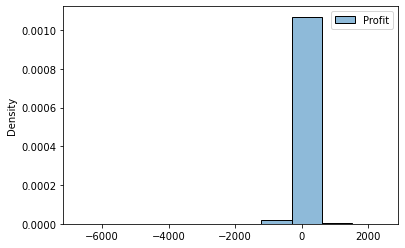

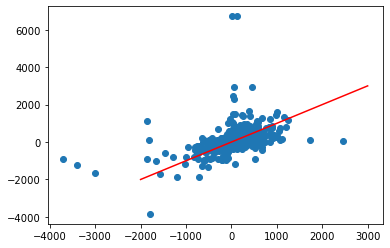

RandomForestRegressor(max_depth=10, n_estimators=20, random_state=2021)
Parâmetros:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': 2021, 'verbose': 0, 'warm_start': False}
Mean Absolute Error:  43.53927026467627
Mean Squared Error:  14262.03673993267
RMSE:  119.4237695768002


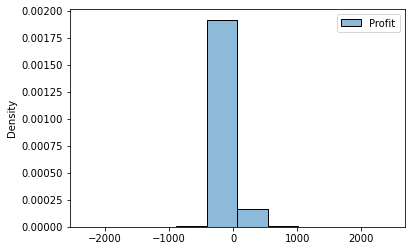

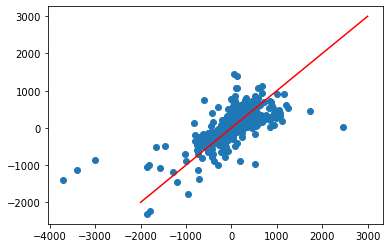

array([[272.35063948],
       [ 12.09672235],
       [  8.43801428],
       ...,
       [-10.77937873],
       [  3.51266993],
       [ -5.20381565]])

In [15]:
dtr = DecisionTreeRegressor(random_state=RANDOM_SEED)
rfr = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='squared_error', random_state=RANDOM_SEED )
analise_model(dtr)

analise_model(rfr, y_train.values.ravel() )


In [20]:
# Veio daqui:
# https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/


def hyper_param(model, params, y_train_analise=y_train):
    print("Modelo atual: " , model)
    
    # cv = cross-validation generator
    # verbose = quanto é apresentado
    tuning_model=GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=3)
    tuning_model.fit(X_train, y_train_analise)
    
    return tuning_model.best_params_
    

Modelo atual:  DecisionTreeRegressor(random_state=2021)
Melhores parâmetros:  {'max_depth': 3, 'max_features': 'auto', 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=2021)
time - 0.06491422653198242
DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=2021)
Parâmetros:
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 2021, 'splitter': 'best'}
Mean Absolute Error:  53.694399971604135
Mean Squared Error:  18018.00669484399
RMSE:  134.2311688649249


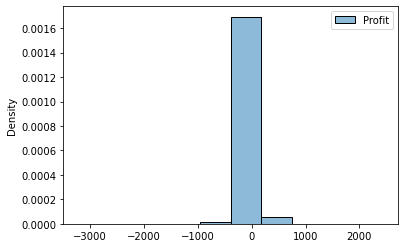

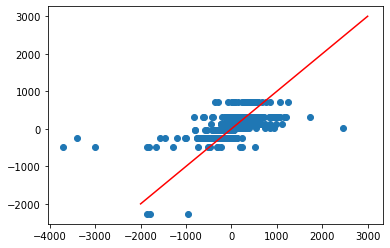

Modelo atual:  RandomForestRegressor(max_depth=10, n_estimators=20, random_state=2021)
Melhores parâmetros:  {'bootstrap': True, 'max_features': 'auto', 'n_estimators': 120}
RandomForestRegressor(max_depth=10, n_estimators=120, random_state=2021)
time - 13.323087215423584
RandomForestRegressor(max_depth=10, n_estimators=120, random_state=2021)
Parâmetros:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120, 'n_jobs': None, 'oob_score': False, 'random_state': 2021, 'verbose': 0, 'warm_start': False}
Mean Absolute Error:  42.78806967222239
Mean Squared Error:  13553.41620229944
RMSE:  116.41914018879989


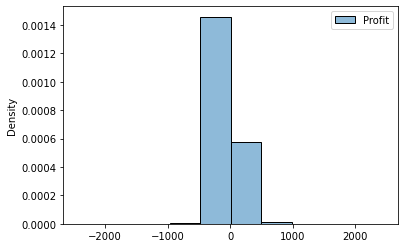

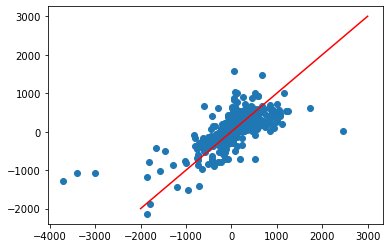

In [25]:

# Inclui os parâmetros default
parametersDRT={"splitter":["best","random"],
            "max_depth" : [2,3,7, None],

           "min_weight_fraction_leaf":[0.0, 0.2,0.5],
           "max_features":["auto","log2","sqrt",None],
           }


best_param1 = hyper_param(dtr, parametersDRT)

best_dtr = DecisionTreeRegressor(random_state=RANDOM_SEED)
print("Melhores parâmetros: ", best_param1)
print(best_dtr.set_params(**best_param1))
analise_model(best_dtr)


parametersRFR = {
            "n_estimators" : [100,120,150],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }

best_param2 = hyper_param(rfr,parametersRFR, y_train.values.ravel())
best_rfr = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='squared_error', random_state=RANDOM_SEED)
print("Melhores parâmetros: ", best_param2)
print(best_rfr.set_params(**best_param2))
predictions = analise_model(best_rfr, y_train.values.ravel())




# Análise da coluna objetivo

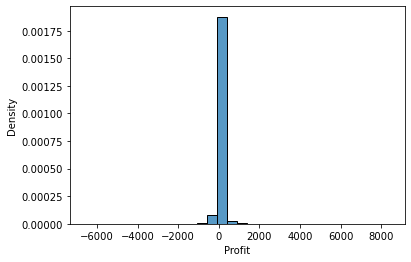

Quartis
[-6599.978      0.         9.2551    36.8415  8399.976 ]


In [28]:
sns.histplot(dataset['Profit'], bins=30,stat="density")
plt.show()
    
x = np.quantile(dataset['Profit'], [0,0.25,0.5,0.75,1])
print("Quartis")
print(x)
#plt.scatter(y_test,predictions)
#plt.show()